In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

In [ ]:
# Pastikan kaggle.json sudah diatur dengan benar
os.environ["KAGGLE_CONFIG_DIR"] = "/path/to/.kaggle"

# Unduh dataset
os.system("kaggle datasets download -d arizbw/traditional-food-knowledge-of-indonesia")

# Ekstrak dataset
import zipfile
with zipfile.ZipFile("traditional-food-knowledge-of-indonesia.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")

print("Dataset downloaded and extracted.")

Dataset downloaded and extracted.


In [ ]:
csv_train = '/content/dataset/train.csv'
csv_test = '/content/dataset/test.csv'
csv_val = '/content/dataset/dev.csv'

images_path = '/content/dataset/food-tfk-images'

data_train = pd.read_csv(csv_train)
data_test = pd.read_csv(csv_test)
data_val = pd.read_csv(csv_val)

print(data_train.head())

data_train['Image Path'] = data_train['Image Index'].apply(lambda x: os.path.join(images_path, x))
data_test['Image Path'] = data_test['Image Index'].apply(lambda x: os.path.join(images_path, x))
data_val['Image Path'] = data_val['Image Index'].apply(lambda x: os.path.join(images_path, x))

    Image Index  Patient ID Finding Labels  asinan-jakarta  ayam-betutu  \
0  IMG_6886.jpg           1      gado-gado               0            0   
1  IMG_7701.jpg           1    soto-banjar               0            0   
2  IMG_7023.jpg           1   rujak-cingur               0            0   
3  IMG_7407.jpg           1     kue-lumpur               0            0   
4  IMG_7569.jpg           1    soto-banjar               0            0   

   ayam-bumbu-rujak  ayam-goreng-lengkuas  bika-ambon  bir-pletok  \
0                 0                     0           0           0   
1                 0                     0           0           0   
2                 0                     0           0           0   
3                 0                     0           0           0   
4                 0                     0           0           0   

   bubur-manado  ...  rawon-surabaya  rendang  rujak-cingur  sate-ayam-madura  \
0             0  ...               0        0        

In [ ]:
# Fungsi untuk memuat gambar
def load_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Sesuaikan target_size
    img_array = img_to_array(img)
    return img_array

# Menyiapkan direktori untuk menyimpan gambar hasil augmentasi
augmentation_dir = '/content/dataset/augmented_train'
os.makedirs(augmentation_dir, exist_ok=True)

In [ ]:
# Konfigurasi untuk augmentasi
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Loop untuk augmentasi dan menyimpan hasilnya
augmented_images = []
augmented_labels = []

for idx, row in data_train.iterrows():
    image_path = row['Image Path']
    label = row['Finding Labels']

    # Memuat gambar
    img = load_img(image_path, target_size=(224, 224))  # Ubah ukuran gambar
    img_array = img_to_array(img)  # Ubah ke array numpy
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch

    # Augmentasi data gambar
    aug_iter = datagen.flow(img_array, batch_size=1)
    num_augmented = 4  # Set rasio 1:4, 4 gambar augmentasi per gambar asli

    for i in range(num_augmented):
        aug_image = next(aug_iter)[0].astype('uint8')  # Menghasilkan gambar augmentasi
        aug_image_path = os.path.join(augmentation_dir, f"{os.path.splitext(row['Image Index'])[0]}_aug_{i}.jpg")

        # Simpan gambar hasil augmentasi
        tf.keras.preprocessing.image.save_img(aug_image_path, aug_image)

        # Simpan jalur gambar dan label ke dalam daftar
        augmented_images.append(aug_image_path)
        augmented_labels.append(label)

In [ ]:
# Buat DataFrame baru untuk menyimpan data augmented
augmented_data = pd.DataFrame({
    'Image Index': [os.path.basename(img_path) for img_path in augmented_images],
    'Finding Labels': augmented_labels,
    'Image Path': augmented_images
})

# Menggabungkan data asli dan data augmented
data_train_augmented = pd.concat([data_train, augmented_data], ignore_index=True)

# Melihat jumlah data setelah augmentasi
print(f"Jumlah data sebelum augmentasi: {len(data_train)}")
print(f"Jumlah data setelah augmentasi: {len(data_train_augmented)}")

Jumlah data sebelum augmentasi: 1150
Jumlah data setelah augmentasi: 5750


In [ ]:
# Simpan DataFrame baru jika diperlukan
data_train_augmented.to_csv('/content/dataset/train_augmented.csv', index=False)

In [ ]:
# Fungsi generator untuk memuat batch gambar dan label
def image_data_generator(image_paths, labels, batch_size):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_image_paths = image_paths[start:end]
            batch_labels = labels[start:end]
            images = [load_image(img_path) for img_path in batch_image_paths]
            yield np.array(images), np.array(batch_labels)

# Dataset augmented untuk pelatihan
train_paths = data_train_augmented['Image Path'].values
train_labels = data_train_augmented['Finding Labels'].values

val_paths = data_val['Image Path'].values
val_labels = data_val['Finding Labels'].values

test_paths = data_test['Image Path'].values
test_labels = data_test['Finding Labels'].values

batch_size = 32

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Generator data untuk pelatihan dan validasi
train_generator = image_data_generator(train_paths, train_labels_encoded, batch_size)
val_generator = image_data_generator(val_paths, val_labels_encoded, batch_size)


In [ ]:
print("All Labels:")
for label in label_encoder.classes_:
    print(label)


All Labels:
asinan-jakarta
ayam-betutu
ayam-bumbu-rujak
ayam-goreng-lengkuas
bika-ambon
bir-pletok
bubur-manado
cendol
es-dawet
gado-gado
gudeg
gulai-ikan-mas
keladi
kerak-telor
klappertart
kolak
kue-lumpur
kunyit-asam
laksa-bogor
lumpia-semarang
mie-aceh
nagasari
papeda
pempek-palembang
rawon-surabaya
rendang
rujak-cingur
sate-ayam-madura
sate-lilit
sate-maranggi
soerabi
soto-ayam-lamongan
soto-banjar
tahu-telur


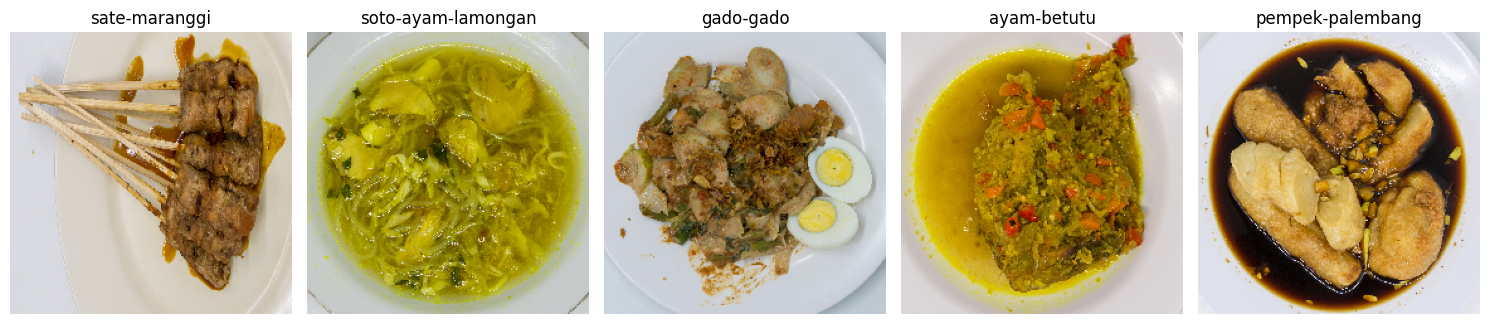

In [ ]:
import matplotlib.pyplot as plt
images, labels = next(train_generator_encoded)

images = np.array(images)
labels = np.array(labels)

def plot_images(images, labels, label_encoder, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(min(len(images), num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].astype('uint8'))
        plt.title(label_encoder.inverse_transform([np.argmax(labels[i])])[0])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot 5 gambar dari batch
plot_images(images, labels, label_encoder, num_images=5)

In [ ]:
img_height, img_width = 224, 224
epochs = 10
num_classes = len(label_encoder.classes_)

print('classes:', num_classes)
base_model = EfficientNetB2(input_shape=(img_height, img_width, 3),
                            include_top=False,
                            weights='imagenet')

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


classes: 34


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)          │ (None, 7, 7, 1408)          │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1024)                │       1,442,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 34)                  │           8,738 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,876,251 (37.67 MB)

 Trainable params: 2,107,682 (8.04 MB)

 Non-trainable params: 7,768,569 (29.63 MB)

In [ ]:
import numpy as np
from sklearn.utils import shuffle

# Calculate class weights
class_counts = np.bincount(train_labels_encoded)
class_weights = {i: max(class_counts) / class_counts[i] for i in range(len(class_counts))}

def image_data_generator_balanced(image_paths, labels_encoded, class_weights, batch_size):
    while True:
        # Shuffle data to randomize batches
        image_paths, labels_encoded = shuffle(image_paths, labels_encoded)

        # Initialize variables to store batch data
        batch_images = []
        batch_labels = []

        # Track counts of each class in the current batch
        class_counts = {cls: 0 for cls in range(len(class_weights))}

        for i, image_path in enumerate(image_paths):
            # Load and preprocess image
            image = load_image(image_path)
            label = labels_encoded[i]

            # Check if adding this sample will maintain balance
            if class_counts[label] < int(batch_size * class_weights[label]):
                batch_images.append(image)
                batch_labels.append(label)
                class_counts[label] += 1

            # Yield batch if it reaches the desired size
            if len(batch_images) >= batch_size:
                yield np.array(batch_images), to_categorical(np.array(batch_labels), num_classes=len(class_weights))
                batch_images = []
                batch_labels = []
                class_counts = {cls: 0 for cls in range(len(class_weights))}

        # Yield remaining batch
        if batch_images:
            yield np.array(batch_images), to_categorical(np.array(batch_labels), num_classes=len(class_weights))

# Usage example
train_generator_balanced = image_data_generator_balanced(train_paths, train_labels_encoded, class_weights, batch_size)
val_generator_balanced = image_data_generator_balanced(val_paths, val_labels_encoded, class_weights, batch_size)
test_generator_balanced = image_data_generator_balanced(test_paths, test_labels_encoded, class_weights, batch_size)

In [ ]:
train_steps_per_epoch = len(train_paths) // batch_size
val_steps_per_epoch = len(val_paths) // batch_size

history = model.fit(
    train_generator_balanced,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator_balanced,
    validation_steps=val_steps_per_epoch
)

model.save('model.h5')

loss, accuracy = model.evaluate(val_generator_encoded, steps=val_steps_per_epoch)
print(f'Validation loss: {loss}')
print(f'Validation accuracy: {accuracy}')

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 121s 470ms/step - accuracy: 0.5074 - loss: 1.8277 - val_accuracy: 1.0000 - val_loss: 9.8580e-04
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 103s 443ms/step - accuracy: 0.9740 - loss: 0.0858 - val_accuracy: 1.0000 - val_loss: 2.2659e-04
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 72s 401ms/step - accuracy: 0.9900 - loss: 0.0361 - val_accuracy: 1.0000 - val_loss: 3.7109e-05
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 74s 413ms/step - accuracy: 0.9902 - loss: 0.0386 - val_accuracy: 1.0000 - val_loss: 8.8817e-06
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 401ms/step - accuracy: 0.9963 - loss: 0.0117 - val_accuracy: 1.0000 - val_loss: 3.8488e-05
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 388ms/step - accuracy: 0.9855 - loss: 0.0487 - val_accuracy: 1.0000 - val_loss: 2.6888e-05
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 423ms/step - accuracy: 0.9849 - loss: 0.0499 - val_accuracy: 1.0000 - val_loss: 3.1216e-06
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 72s 403ms/ste

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 1.0000 - loss: 1.0784e-05
Validation loss: 5.6946832955873106e-06
Validation accuracy: 1.0


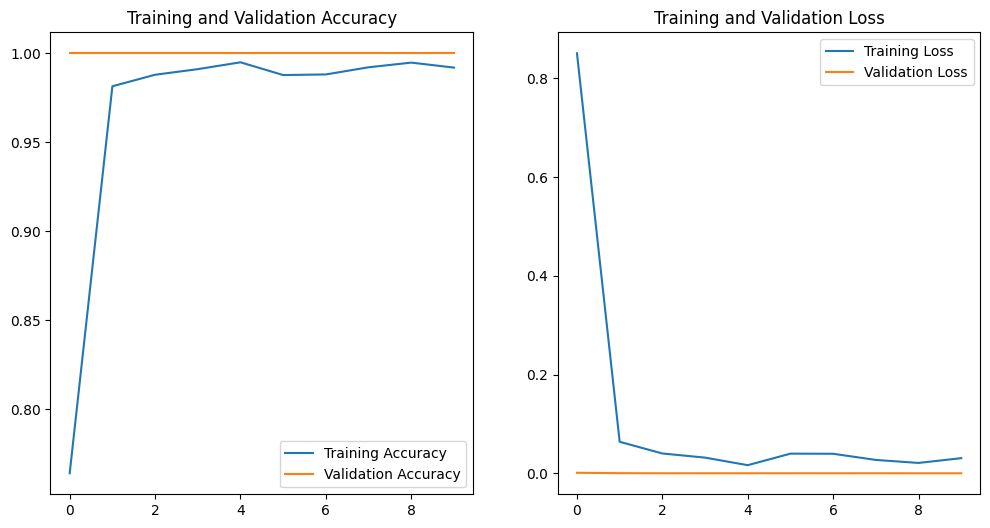

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 1.0000 - loss: 7.2318e-06
Test loss: 4.366902885521995e-06
Test accuracy: 1.0


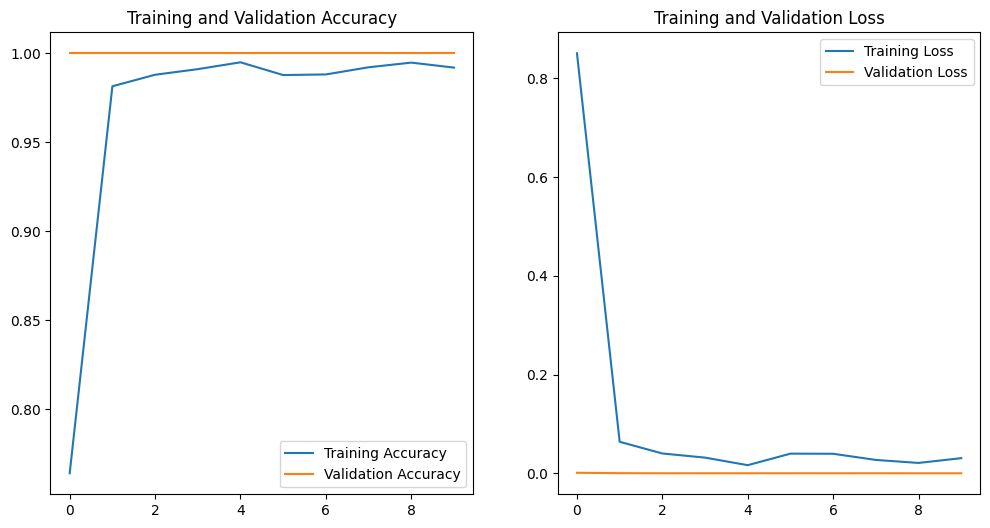

In [ ]:
test_steps_per_epoch = len(test_paths) // batch_size

test_loss, test_accuracy = model.evaluate(test_generator_encoded, steps=test_steps_per_epoch)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)          │ (None, 7, 7, 1408)          │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1024)                │       1,442,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 34)                  │           8,738 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,876,253 (37.67 MB)

 Trainable params: 2,107,682 (8.04 MB)

 Non-trainable params: 7,768,569 (29.63 MB)

 Optimizer params: 2 (12.00 B)

11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
Classification Report:
                       precision    recall  f1-score   support

      asinan-jakarta       1.00      1.00      1.00        10
         ayam-betutu       1.00      1.00      1.00        11
    ayam-bumbu-rujak       1.00      1.00      1.00        13
ayam-goreng-lengkuas       1.00      1.00      1.00        13
          bika-ambon       1.00      1.00      1.00         7
          bir-pletok       1.00      1.00      1.00         8
        bubur-manado       1.00      1.00      1.00        10
              cendol       1.00      1.00      1.00        14
            es-dawet       1.00      1.00      1.00        11
           gado-gado       1.00      1.00      1.00         6
               gudeg       1.00      1.00      1.00         4
      gulai-ikan-mas       1.00      1.00      1.00         4
              keladi       1.00      1.00      1.00         9
         kerak-telor       1.00      1.00      1.00         6
      

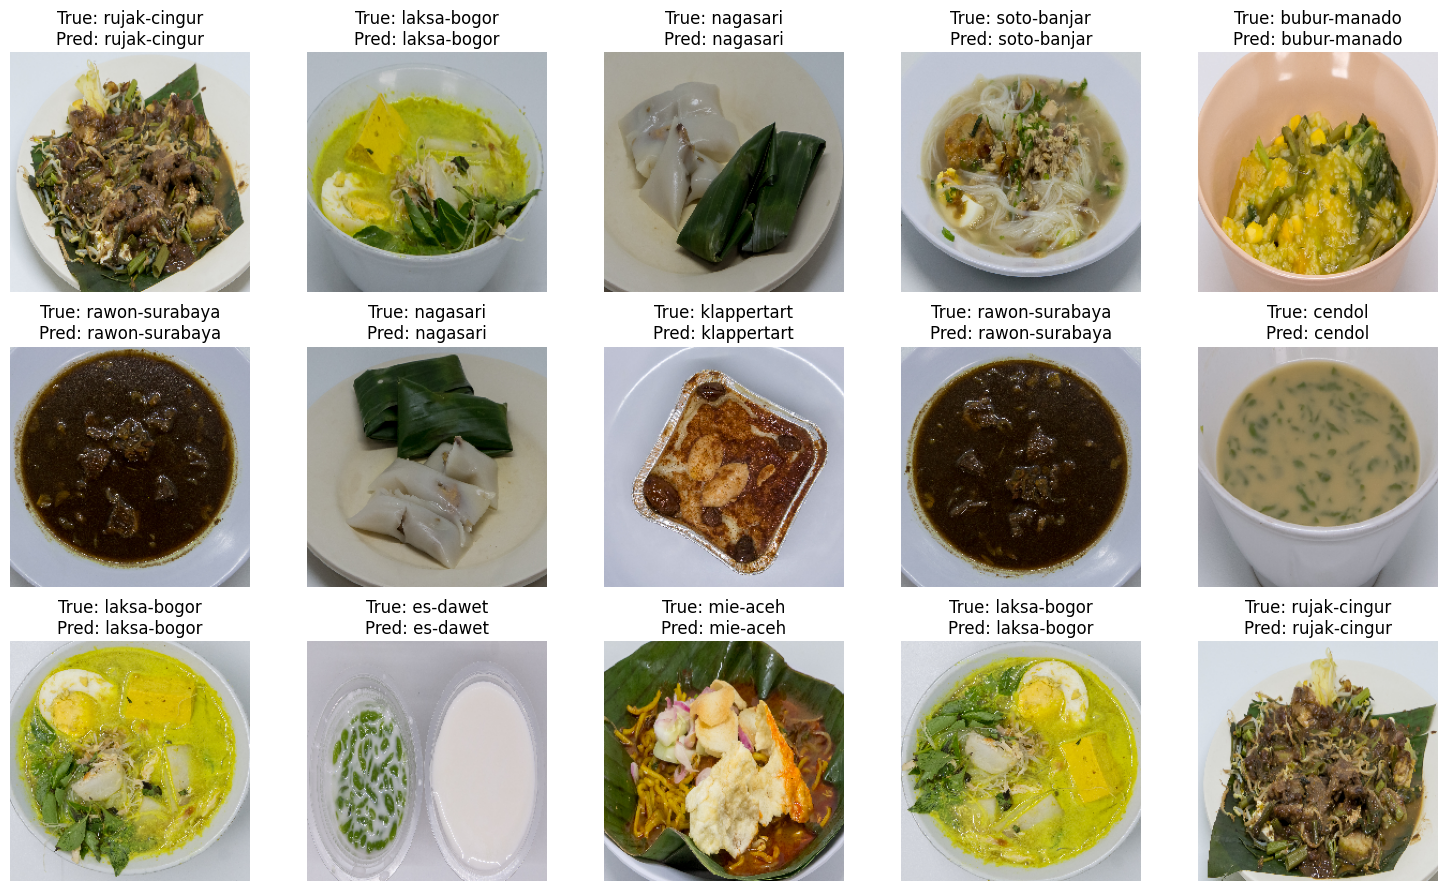

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report
from tensorflow.keras.applications.efficientnet import preprocess_input

model = load_model('model.h5')

def load_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

test_images = np.vstack([load_image(path) for path in test_paths])
test_labels_encoded = np.array(test_labels_encoded)

predictions = model.predict(test_images, verbose=1)

predicted_classes = np.argmax(predictions, axis=1)

predicted_labels = label_encoder.inverse_transform(predicted_classes)
true_labels = label_encoder.inverse_transform(test_labels_encoded)

print("Classification Report:\n", classification_report(true_labels, predicted_labels))

num_images_to_display = 15
images_per_row = 5
random_indices = np.random.choice(len(test_paths), num_images_to_display, replace=False)
num_rows = (num_images_to_display + images_per_row - 1) // images_per_row

plt.figure(figsize=(15, 3 * num_rows))

for i, idx in enumerate(random_indices):
    img_path = test_paths[idx]
    img = load_img(img_path, target_size=(224, 224))
    true_label = true_labels[idx]
    predicted_label = predicted_labels[idx]

    plt.subplot(num_rows, images_per_row, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


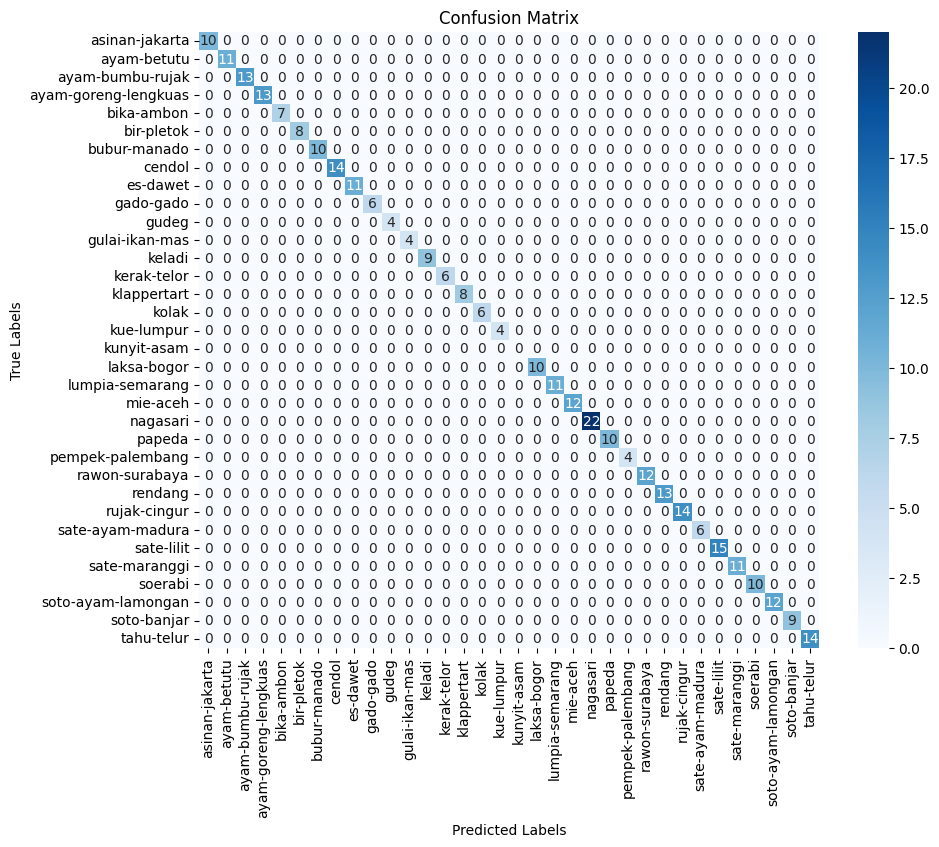

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels, labels=label_encoder.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Convert to JSON

In [ ]:
from tensorflow.keras.models import load_model
import json

model = load_model('model.h5')

model_json = model.to_json()

with open('model_structure.json', 'w') as json_file:
    json_file.write(model_json)


In [ ]:
from tensorflow.keras.models import load_model, model_from_json
import json
import os

model = load_model('model.h5')

model_json = model.to_json()

with open('model_structure.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('model_weights.weights.h5')

print("Files saved:", os.listdir('.'))

with open('model_structure.json', 'r') as json_file:
    loaded_model_json = json_file.read()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('model_weights.weights.h5')
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Files saved: ['.config', 'model_weights.weights.h5', 'model_structure.json', 'augmented_train_images', 'augmented_train.csv', 'dataset', 'traditional-food-knowledge-of-indonesia.zip', 'model.h5', 'sample_data']


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
